In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from keras.preprocessing.image import ImageDataGenerator
import streamlit as st
import mlflow
import dvc.api
from google.cloud import storage

import cv2
import matplotlib.pyplot as plt
import random
import numpy as np

from ultralytics import YOLO
from PIL import Image

In [8]:
global storage_client
global bucket_name
storage_client = storage.Client()
bucket_name = "mlops-car-detection"

def list_blobs(bucket_name):
    # Note: Client.list_blobs requires at least package version 1.17.0.
    blobs = storage_client.list_blobs(bucket_name)
    
    # for blob in blobs:
    #     print(blob.name)
        
    blob_names = [blob.name for blob in blobs if blob.name.endswith('.jpg')]
    return blob_names
    # blob_list_names = [blob.name for blob in blobs if blob.name.endswith(".jpg")]

In [12]:
def display_random_image(bucket_name):
    blob_names = list_blobs(bucket_name)
    if not blob_names:
        print("No .jpg files found in the bucket.")
        return
    
    # Randomly select a blob name
    selected_blob_name = random.choice(blob_names)
    # print("Selected Blob:", selected_blob_name)

    # Download the selected blob
    blob = storage_client.bucket(bucket_name).get_blob(selected_blob_name)
    if blob is None:
        print("Failed to retrieve blob.")
        return

    # Download the blob's content
    blob_content = blob.download_as_bytes()

    # Decode the image content
    nparr = np.frombuffer(blob_content, np.uint8)
    image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    
    # Display the image
    # cv2.imshow("Random Image", image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    return image

# Call the function to display a random image from the specified bucket
display_random_image(bucket_name)

array([[[188, 187, 183],
        [188, 187, 183],
        [188, 187, 183],
        ...,
        [182, 181, 177],
        [182, 181, 177],
        [182, 181, 177]],

       [[188, 187, 183],
        [188, 187, 183],
        [188, 187, 183],
        ...,
        [182, 181, 177],
        [182, 181, 177],
        [182, 181, 177]],

       [[188, 187, 183],
        [188, 187, 183],
        [188, 187, 183],
        ...,
        [182, 181, 177],
        [182, 181, 177],
        [182, 181, 177]],

       ...,

       [[122, 130, 130],
        [121, 129, 129],
        [121, 129, 129],
        ...,
        [111, 116, 119],
        [112, 117, 120],
        [113, 118, 121]],

       [[117, 125, 124],
        [116, 124, 123],
        [116, 124, 123],
        ...,
        [111, 116, 119],
        [111, 116, 119],
        [113, 118, 121]],

       [[118, 126, 125],
        [117, 125, 124],
        [116, 124, 123],
        ...,
        [110, 115, 118],
        [111, 116, 119],
        [112, 117, 120]]

In [9]:
# Use a pretrained YOLOv8n model
model = YOLO("yolov8n.pt")

100%|██████████| 6.23M/6.23M [00:00<00:00, 6.67MB/s]



0: 224x224 (no detections), 40.5ms
Speed: 1.0ms preprocess, 40.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)


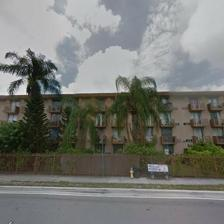

In [41]:
image = display_random_image(bucket_name)
result_predict = model.predict(source = image, imgsz=(224))

# show results
plot = result_predict[0].plot()
plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
display(Image.fromarray(plot))

In [27]:
import mlflow
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

# Define the criterion
criterion = nn.CrossEntropyLoss()

epochs = 10
batch_size = 8
learning_rate = 0.001


In [32]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print device information
print("Using device:", device)

# If GPU is available, you can also print additional information
if device.type == 'cuda':
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("CUDA Version:", torch.version.cuda)

Using device: cpu


In [33]:
class CustomDataset(Dataset):
    def __init__(self, bucket_name, transform=None):
        self.bucket_name = bucket_name
        self.transform = transform

        # Initialize Google Cloud Storage client
        self.storage_client = storage.Client()

        # Get list of blob names in the bucket
        self.blob_names = self.list_blobs()

    def __len__(self):
        return len(self.blob_names)

    def __getitem__(self, idx):
        # Retrieve image from Google Cloud Storage
        blob_name = self.blob_names[idx]
        image = self.download_image(blob_name)

        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)

        return image

    def list_blobs(self):
        blobs = self.storage_client.list_blobs(self.bucket_name)
        blob_names = [blob.name for blob in blobs if blob.name.endswith('.jpg')]
        return blob_names

    def download_image(self, blob_name):
        blob = self.storage_client.bucket(self.bucket_name).get_blob(blob_name)
        if blob is None:
            raise FileNotFoundError(f"Blob '{blob_name}' not found in bucket '{self.bucket_name}'")
        
        # Download the blob's content
        blob_content = blob.download_as_bytes()

        # Decode the image content
        nparr = np.frombuffer(blob_content, np.uint8)
        image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

        # Convert OpenCV image to PIL image
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        return image

In [34]:
# Define transforms for preprocessing (replace with your actual transforms)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # Add more transforms as needed
])

# Assuming you have a CustomDataset class for your dataset
custom_dataset = CustomDataset(bucket_name, transform=transform)

# Define batch size
batch_size = 32

# Create DataLoader
train_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # Add more transformations as needed
])

# Create custom validation dataset instance
val_dataset = CustomDataset(bucket_name, transform=val_transform)

# Define batch size for validation
val_batch_size = 32

# Create DataLoader for validation
val_loader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False)

In [35]:
# Start MLflow run
mlflow.start_run()

# Log parameters
mlflow.log_param('epochs', epochs)
mlflow.log_param('batch_size', batch_size)
mlflow.log_param('learning_rate', learning_rate)

optimizer = optim.Adam(model.parameters(), lr=0.001)


for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100.0 * correct / total
    # Log metrics to MLflow
    mlflow.log_metric('loss', train_loss, step=epoch)
    mlflow.log_metric('accuracy', train_accuracy, step=epoch)
    
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0


    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100.0 * correct / total
    # Log validation metrics to MLflow
    mlflow.log_metric('val_loss', val_loss, step=epoch)
    mlflow.log_metric('val_accuracy', val_accuracy, step=epoch)

# Save the trained model
torch.save(model.state_dict(), 'yolov5_custom.pt')

# Log the model as an artifact in MLflow
mlflow.log_artifact('yolov5_custom.pt')

# End MLflow run
mlflow.end_run()


Ultralytics YOLOv8.2.2  Python-3.11.9 torch-2.2.2+cpu CPU (AMD Ryzen 9 5900HX with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=coco.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_box

100%|██████████| 169M/169M [00:27<00:00, 6.44MB/s] 
Unzipping U:\ZHAW\MLOPs\MLOPs-Cars-detection\datasets\coco2017labels-segments.zip to U:\ZHAW\MLOPs\MLOPs-Cars-detection\datasets\coco...:  21%|██        | 25803/122232 [00:09<00:33, 2843.98file/s]


KeyboardInterrupt: 